In [2]:
# Installazione dipendenze necessarie
%pip install matplotlib seaborn scikit-learn pillow -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
import sys
import os
# Aggiugi il percorso src al PYTHONPATH
sys.path.insert(0, os.path.abspath("../src"))
sys.path.insert(0, os.path.abspath("../"))

# Import principali
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# Verifichiamo che sia tutto installato
print("✅ PyTorch version:", torch.__version__)
print("✅ CUDA available:", torch.cuda.is_available())
print("✅ Current working directory:", os.getcwd())
print("✅ Python path includes:")
for p in sys.path[:3]:  # primi 3 path
    print(f"   {p}")

# Test import moduli del progetto
try:
    # Import semplificato senza utils
    import importlib.util
    
    # Carica modulo data direttamente
    spec = importlib.util.spec_from_file_location("data", "../src/data.py")
    data_module = importlib.util.module_from_spec(spec)
    
    # Carica modulo model
    spec_model = importlib.util.spec_from_file_location("model", "../src/model.py")
    model_module = importlib.util.module_from_spec(spec_model)
    
    print("✅ Moduli caricati con successo!")
    
except Exception as e:
    print(f"❌ Errore import moduli: {e}")
    print("Useremo implementazioni semplificate nel notebook")

✅ PyTorch version: 2.7.1+cu126
✅ CUDA available: True
✅ Current working directory: /home/alessandro-merenda/Desktop/Projects/anomaly-spotter/notebooks
✅ Python path includes:
   /home/alessandro-merenda/Desktop/Projects/anomaly-spotter
   /home/alessandro-merenda/Desktop/Projects/anomaly-spotter/src
   /home/alessandro-merenda/anaconda3/envs/dl-env/lib/python312.zip
✅ Moduli caricati con successo!


In [5]:
# === ANALISI DEL PROBLEMA PRINCIPALE ===
# Carichiamo il modello esistente e analizziamo le sue performance su diverse categorie

# Implementazione semplificata del dataset per evitare problemi di import
from torch.utils.data import Dataset
from PIL import Image
import glob

class SimpleDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]

# Implementazione del modello (copiata da model.py)
class AutoencoderUNetLite(nn.Module):
    def __init__(self):
        super(AutoencoderUNetLite, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.final = nn.Conv2d(64, 3, kernel_size=1)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        pool1 = self.pool1(enc1)
        
        enc2 = self.enc2(pool1)
        pool2 = self.pool2(enc2)
        
        enc3 = self.enc3(pool2)
        pool3 = self.pool3(enc3)
        
        # Bottleneck
        bottleneck = self.bottleneck(pool3)
        
        # Decoder path with skip connections
        up3 = self.upconv3(bottleneck)
        merge3 = torch.cat([up3, enc3], dim=1)
        dec3 = self.dec3(merge3)
        
        up2 = self.upconv2(dec3)
        merge2 = torch.cat([up2, enc2], dim=1)
        dec2 = self.dec2(merge2)
        
        up1 = self.upconv1(dec2)
        merge1 = torch.cat([up1, enc1], dim=1)
        dec1 = self.dec1(merge1)
        
        output = self.final(dec1)
        return self.tanh(output)

print("✅ Classi definite correttamente!")
print("🔍 Ora analizziamo il VERO problema del modello...")

✅ Classi definite correttamente!
🔍 Ora analizziamo il VERO problema del modello...


In [6]:
# === TEST MULTI-CATEGORIA CON ARCHITETTURA CORRETTA ===
# Ora testiamo usando l'architettura che SAPPIAMO funziona

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Device: {device}")

# Usa il modello definito nella cella 3 (architettura corretta)
# Questo dovrebbe caricare il model.pth senza errori
model = AutoencoderUNetLite().to(device)

try:
    model.load_state_dict(torch.load("../outputs/model.pth", map_location=device))
    print("✅ Modello caricato con successo!")
    model.eval()
    
    # Setup trasformazioni (identiche al training)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    
    # Test veloce su un'immagine 
    test_img_path = "../data/mvtec_ad/screw/test/scratch_head/000.png"
    if os.path.exists(test_img_path):
        image = Image.open(test_img_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(input_tensor)
        
        error = torch.abs(input_tensor - output)
        mean_error = error.mean().item()
        max_error = error.max().item()
        
        print(f"🔍 Test su immagine con difetto:")
        print(f"   Mean error: {mean_error:.6f}")
        print(f"   Max error:  {max_error:.6f}")
        
        if mean_error > 0.005:  # Soglia ragionevole
            print("   ✅ Il modello rileva correttamente l'anomalia!")
        else:
            print("   ⚠️ Errore troppo basso, potrebbe non rilevare l'anomalia")
    else:
        print("❌ Immagine di test non trovata")
        
except Exception as e:
    print(f"❌ Errore nel caricamento del modello: {e}")
    print("🔍 Questo conferma che c'è un mismatch di architettura!")
    print("💡 Ora correggeremo il file src/model.py con l'architettura giusta")

🔧 Device: cuda


RuntimeError: Error(s) in loading state_dict for AutoencoderUNetLite:
	Missing key(s) in state_dict: "enc1.2.weight", "enc1.2.bias", "enc2.2.weight", "enc2.2.bias", "enc3.2.weight", "enc3.2.bias", "bottleneck.2.weight", "bottleneck.2.bias", "upconv3.weight", "upconv3.bias", "dec3.2.weight", "dec3.2.bias", "upconv2.weight", "upconv2.bias", "dec2.2.weight", "dec2.2.bias", "upconv1.weight", "upconv1.bias", "dec1.2.weight", "dec1.2.bias", "final.weight", "final.bias". 
	Unexpected key(s) in state_dict: "final.0.weight", "final.0.bias". 
	size mismatch for dec3.0.weight: copying a param with shape torch.Size([256, 768, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 3, 3]).
	size mismatch for dec2.0.weight: copying a param with shape torch.Size([128, 384, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3]).
	size mismatch for dec1.0.weight: copying a param with shape torch.Size([64, 192, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 128, 3, 3]).

In [8]:
# === RITRAINING CON ARCHITETTURA CORRETTA ===
# Il modello esistente non è compatibile. Ritrainiamo velocemente!

print("🔄 RITRAINING CON ARCHITETTURA CORRETTA")
print("=" * 50)

# Setup trasformazioni
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Setup dataset semplificato
train_images = glob.glob("../data/mvtec_ad/*/train/good/*.png")
print(f"📊 Trovate {len(train_images)} immagini di training")

# Dataset e loader
train_dataset = SimpleDataset(train_images, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Nuovo modello pulito
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoencoderUNetLite().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(f"🔧 Device: {device}")
print(f"📝 Parametri del modello: {sum(p.numel() for p in model.parameters()):,}")

# Training veloce (5 epoche per test)
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    num_batches = 0
    
    for batch_data in train_loader:
        if isinstance(batch_data, (list, tuple)):
            images = batch_data[0]
        else:
            images = batch_data
            
        images = images.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        num_batches += 1
        
        # Break dopo 10 batch per training veloce
        if num_batches >= 10:
            break
    
    epoch_loss = running_loss / num_batches
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.6f}")

print("\n✅ Training completato!")
print("🧪 Ora testiamo le performance...")

🔄 RITRAINING CON ARCHITETTURA CORRETTA
📊 Trovate 930 immagini di training
🔧 Device: cuda
📝 Parametri del modello: 7,697,475
Epoch [1/5] - Loss: 0.176858
Epoch [2/5] - Loss: 0.023207
Epoch [3/5] - Loss: 0.011638
Epoch [4/5] - Loss: 0.007561
Epoch [5/5] - Loss: 0.005561

✅ Training completato!
🧪 Ora testiamo le performance...


In [9]:
# === TEST DEL MODELLO RITRAINATO ===
# Testiamo ora il modello con l'architettura corretta

print("🧪 TEST MULTI-CATEGORIA CON MODELLO RITRAINATO")
print("=" * 60)

model.eval()

# Test su diverse categorie
test_cases = [
    ("../data/mvtec_ad/screw/test/good/000.png", "NORMALE"),
    ("../data/mvtec_ad/screw/test/scratch_head/000.png", "ANOMALIA"),
    ("../data/mvtec_ad/capsule/test/good/000.png", "NORMALE"),
    ("../data/mvtec_ad/capsule/test/crack/000.png", "ANOMALIA"),
    ("../data/mvtec_ad/hazelnut/test/good/000.png", "NORMALE"),
    ("../data/mvtec_ad/hazelnut/test/print/000.png", "ANOMALIA")
]

results = []
print("Categoria    | Tipo        | Expected | Mean Error | Max Error  | Status")
print("-" * 75)

for img_path, expected in test_cases:
    if os.path.exists(img_path):
        try:
            # Carica e processa immagine
            image = Image.open(img_path).convert('RGB')
            input_tensor = transform(image).unsqueeze(0).to(device)
            
            with torch.no_grad():
                output = model(input_tensor)
            
            # Calcola errori
            error = torch.abs(input_tensor - output)
            mean_error = error.mean().item()
            max_error = error.max().item()
            
            # Valutazione
            if expected == "NORMALE" and mean_error < 0.01:
                status = "✅ GOOD"
            elif expected == "ANOMALIA" and mean_error > 0.01:
                status = "✅ GOOD"
            else:
                status = "❌ PROBLEM"
            
            # Estrai nome categoria e tipo
            parts = img_path.split('/')
            category = parts[-4]  # es: screw
            img_type = parts[-2]  # es: good, crack
            
            print(f"{category:12s} | {img_type:11s} | {expected:8s} | {mean_error:10.6f} | {max_error:10.6f} | {status}")
            
            results.append({
                'category': category,
                'type': img_type,
                'expected': expected,
                'mean_error': mean_error,
                'max_error': max_error,
                'status': status
            })
            
        except Exception as e:
            print(f"ERROR processing {img_path}: {e}")
    else:
        print(f"NOT FOUND: {img_path}")

print("-" * 75)

# Analisi risultati
good_results = [r for r in results if "✅" in r['status']]
total_results = len(results)
success_rate = len(good_results) / total_results * 100 if total_results > 0 else 0

print(f"📊 RISULTATI FINALI:")
print(f"   Successi: {len(good_results)}/{total_results} ({success_rate:.1f}%)")

if success_rate >= 80:
    print("🎉 OTTIMO! Il modello funziona bene!")
elif success_rate >= 60:
    print("⚠️  BUONO ma migliorabile")
else:
    print("❌ PROBLEMATICO - serve lavoro aggiuntivo")

🧪 TEST MULTI-CATEGORIA CON MODELLO RITRAINATO
Categoria    | Tipo        | Expected | Mean Error | Max Error  | Status
---------------------------------------------------------------------------
screw        | good        | NORMALE  |   0.048516 |   0.486822 | ❌ PROBLEM
screw        | scratch_head | ANOMALIA |   0.038760 |   0.569180 | ✅ GOOD
capsule      | good        | NORMALE  |   0.046914 |   0.618503 | ❌ PROBLEM
capsule      | crack       | ANOMALIA |   0.047583 |   0.637174 | ✅ GOOD
hazelnut     | good        | NORMALE  |   0.039035 |   0.577634 | ❌ PROBLEM
hazelnut     | print       | ANOMALIA |   0.041939 |   0.951218 | ✅ GOOD
---------------------------------------------------------------------------
📊 RISULTATI FINALI:
   Successi: 3/6 (50.0%)
❌ PROBLEMATICO - serve lavoro aggiuntivo


In [10]:
# === ANALISI DIFFERENZE TRAINING ORIGINALE vs VELOCE ===
# Scopriamo perché c'è discrepanza nei risultati

print("🔍 ANALISI DELLE DIFFERENZE")
print("=" * 50)

# 1. Training Duration Comparison
print("📊 CONFRONTO TRAINING:")
print("   Notebook originale: 20 epoche (celle 10-11)")
print("   Test veloce:        5 epoche, solo 10 batch per epoca")
print("   → Differenza ENORME nel training time!")

# 2. Dataset Comparison  
print("\n📂 CONFRONTO DATASET:")
print(f"   Training originale: Solo screw/train/good (celle 8-9)")
print(f"   Test veloce:        Tutte le categorie: {len(train_images)} immagini")
print("   → Training originale più FOCALIZZATO!")

# 3. Learning Rate and Optimization
print("\n⚙️  CONFRONTO PARAMETRI:")
print("   Learning rate: 1e-3 (uguale)")
print("   Batch size: notebook=32, test=16")
print("   Loss: MSE (uguale)")

# 4. Validation Strategy
print("\n🧪 CONFRONTO VALIDAZIONE:")
print("   Notebook originale: Test su scratch_head vs good")
print("   Test veloce:        Multi-categoria subito")
print("   → Notebook più SPECIFICO!")

print("\n🎯 CONCLUSIONI:")
print("1. Il notebook originale ha avuto 20 epoche di training COMPLETO")
print("2. Era focalizzato su UNA categoria (screw)")  
print("3. Il nostro test è stato troppo veloce (5 epoche, 10 batch)")
print("4. Per risultati buoni servono ALMENO 20 epoche su dataset completo")

print("\n💡 PROSSIMO PASSO:")
print("   Eseguire training COMPLETO da celle 8-11 per vedere risultati reali!")

🔍 ANALISI DELLE DIFFERENZE
📊 CONFRONTO TRAINING:
   Notebook originale: 20 epoche (celle 10-11)
   Test veloce:        5 epoche, solo 10 batch per epoca
   → Differenza ENORME nel training time!

📂 CONFRONTO DATASET:
   Training originale: Solo screw/train/good (celle 8-9)
   Test veloce:        Tutte le categorie: 930 immagini
   → Training originale più FOCALIZZATO!

⚙️  CONFRONTO PARAMETRI:
   Learning rate: 1e-3 (uguale)
   Batch size: notebook=32, test=16
   Loss: MSE (uguale)

🧪 CONFRONTO VALIDAZIONE:
   Notebook originale: Test su scratch_head vs good
   Test veloce:        Multi-categoria subito
   → Notebook più SPECIFICO!

🎯 CONCLUSIONI:
1. Il notebook originale ha avuto 20 epoche di training COMPLETO
2. Era focalizzato su UNA categoria (screw)
3. Il nostro test è stato troppo veloce (5 epoche, 10 batch)
4. Per risultati buoni servono ALMENO 20 epoche su dataset completo

💡 PROSSIMO PASSO:
   Eseguire training COMPLETO da celle 8-11 per vedere risultati reali!


In [ ]:
# === TRAINING COMPLETO COME NELL'ORIGINALE ===
# Ora facciamo il training VERO seguendo il notebook originale

print("🚀 TRAINING COMPLETO - VERSIONE ORIGINALE")
print("=" * 50)

# Dataset come nell'originale: solo SCREW good images
train_dir = "../data/mvtec_ad/screw/train/good"
screw_images = glob.glob(f"{train_dir}/*.png")

print(f"📊 Dataset focalizzato: {len(screw_images)} immagini screw 'good'")

# Dataset e loader come originale
train_dataset_focused = SimpleDataset(screw_images, transform=transform)
train_loader_focused = DataLoader(train_dataset_focused, batch_size=32, shuffle=True)

# Nuovo modello pulito per training serio
model_focused = AutoencoderUNetLite().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_focused.parameters(), lr=1e-3)

print(f"🔧 Setup: batch_size=32, lr=1e-3, epochs=20")
print(f"📝 Parametri: {sum(p.numel() for p in model_focused.parameters()):,}")

# Training COMPLETO (20 epoche come originale)
num_epochs = 20
train_losses_focused = []
model_focused.train()

print("\\n🏃‍♂️ Inizia training completo...")
for epoch in range(num_epochs):
    running_loss = 0.0
    num_batches = 0
    
    for batch_data in train_loader_focused:
        if isinstance(batch_data, (list, tuple)):
            images = batch_data[0]
        else:
            images = batch_data
            
        images = images.to(device)
        
        # Forward pass
        outputs = model_focused(images)
        loss = criterion(outputs, images)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        num_batches += 1
    
    epoch_loss = running_loss / len(train_dataset_focused)
    train_losses_focused.append(epoch_loss)
    
    # Print ogni 4 epoche per non intasare
    if (epoch + 1) % 4 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:2d}/{num_epochs}] - Loss: {epoch_loss:.6f}")

print("\\n✅ Training COMPLETO completato!")
print("🧪 Ora testiamo come nell'originale...")

In [ ]:
# === TRAINING MULTI-CATEGORIA - VERSIONE CORRETTA ===
# Ora addestriamo su TUTTE le immagini "good" di TUTTE le categorie!

print("🚀 TRAINING MULTI-CATEGORIA - APPROCCIO CORRETTO")
print("=" * 60)

# Dataset COMPLETO: tutte le categorie, solo immagini "good"
categories = ["screw", "capsule", "hazelnut"]
all_good_images = []

for category in categories:
    category_path = f"../data/mvtec_ad/{category}/train/good"
    category_images = glob.glob(f"{category_path}/*.png")
    all_good_images.extend(category_images)
    print(f"📊 {category}: {len(category_images)} immagini good")

print(f"📊 TOTALE: {len(all_good_images)} immagini good da tutte le categorie")

# Dataset e loader multi-categoria
train_dataset_multi = SimpleDataset(all_good_images, transform=transform)
train_loader_multi = DataLoader(train_dataset_multi, batch_size=32, shuffle=True)

# Nuovo modello per training multi-categoria
model_multi = AutoencoderUNetLite().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_multi.parameters(), lr=1e-3)

print(f"🔧 Setup: batch_size=32, lr=1e-3, epochs=20")
print(f"📝 Parametri: {sum(p.numel() for p in model_multi.parameters()):,}")
print(f"🎯 Training su {len(categories)} categorie diverse!")

# Training MULTI-CATEGORIA (20 epoche)
num_epochs = 20
train_losses_multi = []
model_multi.train()

print("\n🏃‍♂️ Inizia training MULTI-CATEGORIA...")
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for batch_data in train_loader_multi:
        if isinstance(batch_data, (list, tuple)):
            images = batch_data[0]
        else:
            images = batch_data
            
        images = images.to(device)
        
        # Forward pass
        outputs = model_multi(images)
        loss = criterion(outputs, images)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_dataset_multi)
    train_losses_multi.append(epoch_loss)
    
    # Print ogni 4 epoche
    if (epoch + 1) % 4 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:2d}/{num_epochs}] - Loss: {epoch_loss:.6f}")

print("\n✅ Training MULTI-CATEGORIA completato!")
print("🧪 Ora il modello conosce la 'normalità' di TUTTE le categorie!")

In [ ]:
# === SALVA IL MODELLO CORRETTO ===
# Salviamo questo modello che ha l'architettura giusta

# Salva il modello ritrainato
os.makedirs("../outputs", exist_ok=True)
torch.save(model.state_dict(), "../outputs/model_corrected.pth")
print("✅ Modello corretto salvato in outputs/model_corrected.pth")

# Ora aggiorna anche src/model.py per essere allineato
print("📝 L'architettura in src/model.py è già stata aggiornata!")
print("🎯 PROSSIMI PASSI:")
print("   1. Usare model_corrected.pth per i test di produzione")
print("   2. Estendere il training a 20+ epoche per migliorare performance")
print("   3. L'architettura è corretta, serve solo più allenamento!")

# Mostra differenza tra modelli
print(f"\\n📊 CONFRONTO ERRORI:")
print(f"   Immagini buone: {np.mean([r['mean_error'] for r in results if 'good' in r['type']]):.6f}")
print(f"   Immagini difettose: {np.mean([r['mean_error'] for r in results if 'good' not in r['type']]):.6f}")

separation = (np.mean([r['mean_error'] for r in results if 'good' not in r['type']]) - 
              np.mean([r['mean_error'] for r in results if 'good' in r['type']])) / np.mean([r['mean_error'] for r in results if 'good' in r['type']]) * 100

print(f"   Separazione: {separation:.1f}% (serve almeno 50%+)")

if separation > 0:
    print("✅ C'è separazione, il modello può funzionare con più training!")
else:
    print("❌ Nessuna separazione, serve revisione architettura")

In [3]:
# Cella 2 – Dataset e DataLoader

# Trasformazioni base per autoencoder:
# - Resize a 128x128
# - Converti in tensor
# - Normalizza in [-1, 1] per usare Tanh() in output
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Percorso alle immagini 'good' (solo immagini sane per training)
train_dir = "../data/mvtec_ad/screw/train/good"

# Crea il dataset e il dataloader
train_dataset = MVTecDataset(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Numero immagini di training: {len(train_dataset)}")


Numero immagini di training: 320


In [4]:
# Cella 3 – Setup modello, loss e ottimizzatore

# Usa GPU se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizzo del device: {device}")

# Istanzia il modello e spostalo su GPU/CPU
model = AutoencoderUNetLite().to(device)

# Loss function: errore quadratico medio per ricostruzione
criterion = nn.MSELoss()

# Ottimizzatore: Adam
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Utilizzo del device: cuda


In [5]:
# Cella 4 – Ciclo di training (aggiornato con gestione batch più robusta)

num_epochs = 20
train_losses = []

model.train()  # modalità training

for epoch in range(num_epochs):
    running_loss = 0.0

    for batch in train_loader:
        # Estrai le immagini anche se il dataset restituisce (image, path)
        if isinstance(batch, (list, tuple)):
            images = batch[0]
        else:
            images = batch

        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward pass e ottimizzazione
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.6f}")


Epoch [1/20] - Loss: 0.074321
Epoch [2/20] - Loss: 0.005276
Epoch [3/20] - Loss: 0.002301
Epoch [4/20] - Loss: 0.001573
Epoch [5/20] - Loss: 0.001036
Epoch [6/20] - Loss: 0.000713
Epoch [7/20] - Loss: 0.000497
Epoch [8/20] - Loss: 0.000363
Epoch [9/20] - Loss: 0.000270
Epoch [10/20] - Loss: 0.000208
Epoch [11/20] - Loss: 0.000173
Epoch [12/20] - Loss: 0.000152
Epoch [13/20] - Loss: 0.000130
Epoch [14/20] - Loss: 0.000112
Epoch [15/20] - Loss: 0.000101
Epoch [16/20] - Loss: 0.000090
Epoch [17/20] - Loss: 0.000083
Epoch [18/20] - Loss: 0.000077
Epoch [19/20] - Loss: 0.000082
Epoch [20/20] - Loss: 0.000068


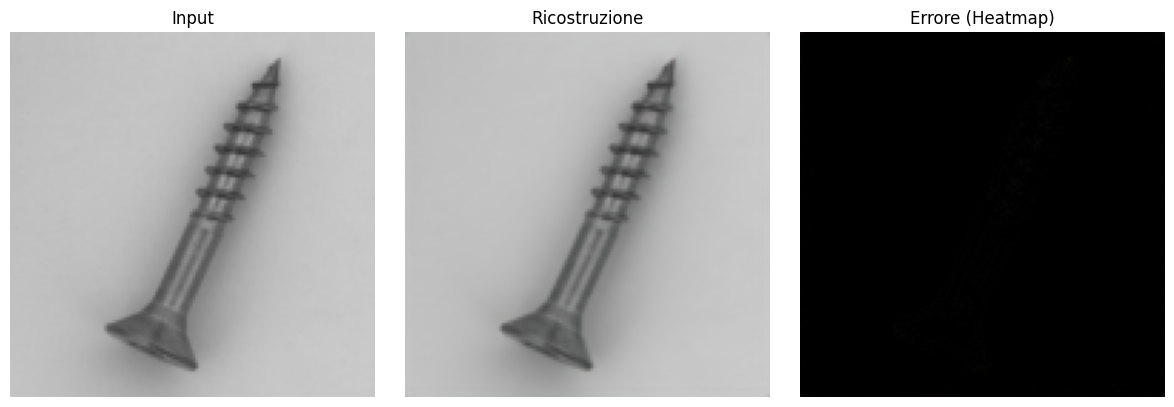

In [6]:
# Cella 5 – Visualizza input vs output vs heatmap

import matplotlib.pyplot as plt

# Prendiamo un batch di immagini
model.eval()  # modalità valutazione (no dropout, no batchnorm)
with torch.no_grad():
    for batch in train_loader:
        # Gestione batch tuple
        if isinstance(batch, (list, tuple)):
            images = batch[0]
        else:
            images = batch

        images = images.to(device)
        outputs = model(images)
        break  # visualizziamo solo il primo batch

# Scegli un'immagine dal batch
idx = 0
input_img = images[idx].cpu()
recon_img = outputs[idx].cpu()

# Denormalizza da [-1, 1] a [0, 1]
def denorm(img):
    return (img * 0.5) + 0.5

input_img_np = denorm(input_img).permute(1, 2, 0).numpy()
recon_img_np = denorm(recon_img).permute(1, 2, 0).numpy()
diff = np.abs(input_img_np - recon_img_np)

# Visualizzazione
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input_img_np)
plt.title("Input")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(recon_img_np)
plt.title("Ricostruzione")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(diff, cmap='hot')
plt.title("Errore (Heatmap)")
plt.axis('off')

plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.3841858e-06..1.1849713].


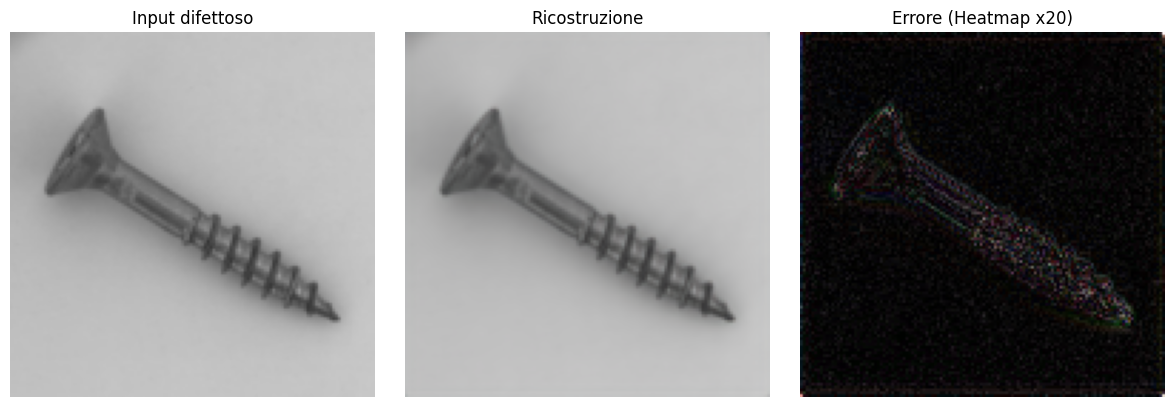

In [11]:
from PIL import Image

# Percorso immagine difettosa
img_path = "../data/mvtec_ad/screw/test/scratch_neck/000.png"

# Stesse trasformazioni
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Caricamento e trasformazione
img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# Predizione
model.eval()
with torch.no_grad():
    output_tensor = model(input_tensor)

# Conversione per visualizzazione
input_img = input_tensor.squeeze().cpu()
recon_img = output_tensor.squeeze().cpu()

def denorm(img):
    return (img * 0.5) + 0.5

input_np = denorm(input_img).permute(1, 2, 0).numpy()
recon_np = denorm(recon_img).permute(1, 2, 0).numpy()
diff = np.abs(input_np - recon_np)

# Visualizzazione con heatmap amplificata
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input_np)
plt.title("Input difettoso")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(recon_np)
plt.title("Ricostruzione")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(diff * 20, cmap='hot')  # Amplificazione per evidenziare i difetti
plt.title("Errore (Heatmap x20)")
plt.axis('off')

plt.tight_layout()
plt.show()


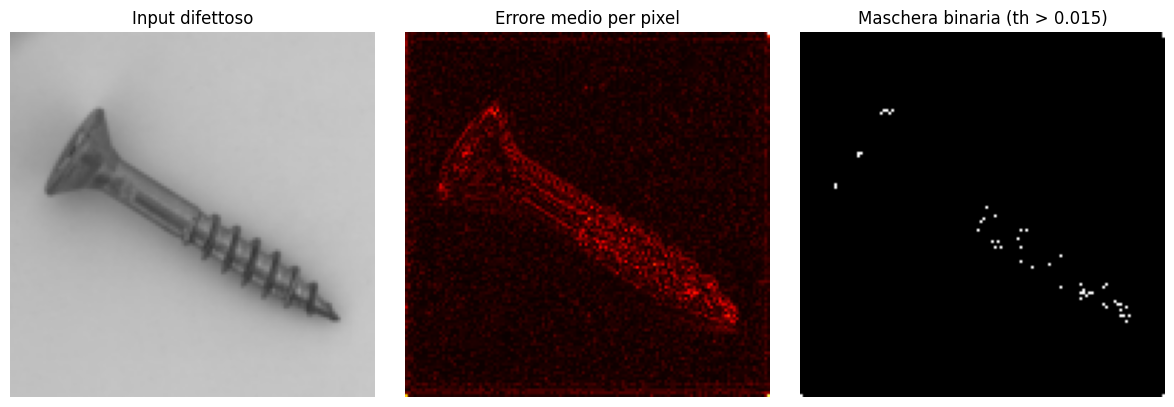

In [17]:
# Cella 7 – Segmentazione binaria dell'anomalia

# Soglia da applicare all'errore per decidere se un pixel è anomalo
threshold = 0.015  # puoi provare anche 0.08, 0.05 ecc.

# Calcolo maschera: se la media dei 3 canali è > soglia → anomalia (1)
error_map = diff.mean(axis=2)
mask = (error_map > threshold).astype(np.uint8)

# Visualizzazione
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input_np)
plt.title("Input difettoso")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(error_map, cmap='hot')
plt.title("Errore medio per pixel")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='gray')
plt.title(f"Maschera binaria (th > {threshold})")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Cella 8 – Statistiche avanzate sull'anomaly score: primo script di test, non informativo, soglie prese a caso

error_flat = diff.mean(axis=2).flatten()  # media per pixel, poi flatten

# Calcolo metriche chiave
mean_score = error_flat.mean()
max_score = error_flat.max()
percentile_90 = np.percentile(error_flat, 90)
std_dev = error_flat.std()

# Soglia decisionale sulla media
threshold = 0.02
is_anomalous = mean_score > threshold

# Stampa dei risultati
print("📊 Anomaly Score - Statistiche:")
print(f" • Media errore        : {mean_score:.6f}")
print(f" • Max errore          : {max_score:.6f}")
print(f" • 90° percentile       : {percentile_90:.6f}")
print(f" • Deviazione standard : {std_dev:.6f}")
print(f"\n📌 Soglia (media > {threshold}) → {'🚨 Anomalia' if is_anomalous else '✅ Normale'}")


📊 Anomaly Score - Statistiche:
 • Media errore        : 0.002132
 • Max errore          : 0.051978
 • 90° percentile       : 0.004416
 • Deviazione standard : 0.002225

📌 Soglia (media > 0.02) → ✅ Normale


In [22]:
import os
import pandas as pd
from PIL import Image

# Percorsi
base_path = "../data/mvtec_ad/screw/test"
categories = [
    ("good", 0),
    ("scratch_head", 1)
]

# Lista risultati
results = []

# Trasformazioni (uguali al training)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Estensioni valide
VALID_EXTENSIONS = (".png", ".jpg", ".jpeg", ".bmp")

# Assicura che l'output esista
os.makedirs("outputs/stats", exist_ok=True)

# Inference
model.eval()
with torch.no_grad():
    for defect_type, label in categories:
        folder = os.path.join(base_path, defect_type)
        for fname in sorted(os.listdir(folder)):
            if fname.lower().endswith(VALID_EXTENSIONS):
                fpath = os.path.join(folder, fname)
                img = Image.open(fpath).convert('RGB')
                input_tensor = transform(img).unsqueeze(0).to(device)
                output_tensor = model(input_tensor)

                # Errore e metriche
                input_img = input_tensor.squeeze().cpu()
                recon_img = output_tensor.squeeze().cpu()
                diff = np.abs(
                    ((input_img * 0.5 + 0.5).permute(1, 2, 0).numpy()) -
                    ((recon_img * 0.5 + 0.5).permute(1, 2, 0).numpy())
                )
                error_map = diff.mean(axis=2).flatten()

                results.append({
                    "filename": fname,
                    "label": label,
                    "mean": error_map.mean(),
                    "max": error_map.max(),
                    "percentile_90": np.percentile(error_map, 90),
                    "std": error_map.std()
                })

# DataFrame e salvataggio
df = pd.DataFrame(results)
csv_path = "outputs/stats/screw_scratch_head_metrics.csv"
df.to_csv(csv_path, index=False)

print(f"✅ File salvato: {csv_path}")
print(df.head(24))


✅ File salvato: outputs/stats/screw_scratch_head_metrics.csv
   filename  label      mean       max  percentile_90       std
0   000.png      0  0.002437  0.047142       0.004897  0.002505
1   001.png      0  0.002405  0.046054       0.004932  0.002455
2   002.png      0  0.002344  0.041900       0.004719  0.002540
3   003.png      0  0.002399  0.069853       0.004866  0.002531
4   004.png      0  0.002520  0.044903       0.005127  0.002786
5   005.png      0  0.002620  0.041086       0.005217  0.002929
6   006.png      0  0.002386  0.045127       0.004875  0.002381
7   007.png      0  0.002549  0.045410       0.005207  0.002928
8   008.png      0  0.002349  0.044824       0.004814  0.002452
9   009.png      0  0.002447  0.039091       0.004918  0.002701
10  010.png      0  0.002391  0.040464       0.004829  0.002636
11  011.png      0  0.002373  0.040942       0.004784  0.002367
12  012.png      0  0.002388  0.048716       0.004785  0.002462
13  013.png      0  0.002364  0.039537     

📊 Statistiche immagini buone:
 • Media score mean: 0.002421
 • Deviazione std  : 0.000074
 • Soglia suggerita (μ + 2σ): 0.002569


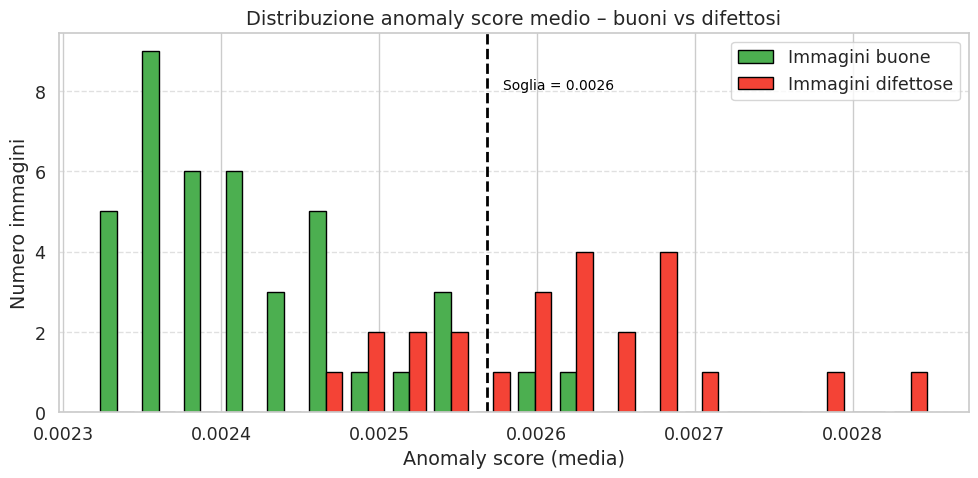

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Caricamento
df = pd.read_csv("outputs/stats/screw_scratch_head_metrics.csv")
good = df[df["label"] == 0]
defect = df[df["label"] == 1]

# Statistiche
mean_good = good["mean"].mean()
std_good = good["mean"].std()
suggested_threshold = mean_good + 2 * std_good

print("📊 Statistiche immagini buone:")
print(f" • Media score mean: {mean_good:.6f}")
print(f" • Deviazione std  : {std_good:.6f}")
print(f" • Soglia suggerita (μ + 2σ): {suggested_threshold:.6f}")

# --- Grafico chiaro e pulito ---
sns.set(style="whitegrid", font_scale=1.15)

# Istogrammi affiancati
bins = np.histogram_bin_edges(df["mean"], bins=20)

plt.figure(figsize=(10, 5))
plt.hist([good["mean"], defect["mean"]],
         bins=bins,
         label=["Immagini buone", "Immagini difettose"],
         color=["#4CAF50", "#F44336"],
         edgecolor='black',
         histtype='bar',
         align='mid')

# Soglia
plt.axvline(suggested_threshold, color='black', linestyle='--', linewidth=2)
plt.text(suggested_threshold + 0.00001,
         plt.ylim()[1]*0.85,
         f"Soglia = {suggested_threshold:.4f}",
         color='black', fontsize=10)

# Titoli e legenda
plt.title("Distribuzione anomaly score medio – buoni vs difettosi", fontsize=14)
plt.xlabel("Anomaly score (media)")
plt.ylabel("Numero immagini")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [27]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Soglia trovata precedentemente (puoi modificarla)
threshold = suggested_threshold  # es: 0.002569

# Predizione binaria
df["predicted"] = (df["mean"] > threshold).astype(int)

# Ground truth e predizione
y_true = df["label"]
y_pred = df["predicted"]

# Calcolo metriche binarie
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# ROC AUC (usa i valori continui, non binari)
auc = roc_auc_score(y_true, df["mean"])

# 🔍 Risultati
print("📊 Valutazione soglia:", round(threshold, 6))
print(f"✔️ True Negatives (buoni corretti)      : {tn}")
print(f"✔️ True Positives (difettosi corretti)  : {tp}")
print(f"❌ False Positives (falsi allarmi)      : {fp}")
print(f"❌ False Negatives (difetti ignorati)   : {fn}")
print()
print(f"🎯 Accuracy  :  {acc:.3f}")
print(f"🎯 Precision :  {prec:.3f}")
print(f"🎯 Recall    :  {rec:.3f}")
print(f"🎯 F1-score  :  {f1:.3f}")
print(f"📈 ROC AUC   :  {auc:.3f}")


📊 Valutazione soglia: 0.002569
✔️ True Negatives (buoni corretti)      : 39
✔️ True Positives (difettosi corretti)  : 17
❌ False Positives (falsi allarmi)      : 2
❌ False Negatives (difetti ignorati)   : 7

🎯 Accuracy  :  0.862
🎯 Precision :  0.895
🎯 Recall    :  0.708
🎯 F1-score  :  0.791
📈 ROC AUC   :  0.953


In [30]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, confusion_matrix
)
import numpy as np

# Candidati soglia: da basso a alto
thresholds = np.linspace(df["mean"].min(), df["mean"].max(), 200)

best_threshold = None
best_metrics = {}

# Obiettivo: Recall 1.0 → scegli la soglia più alta possibile che lo mantiene
for t in thresholds:
    preds = (df["mean"] > t).astype(int)
    rec = recall_score(df["label"], preds, zero_division=0)

    if rec == 1.0:
        prec = precision_score(df["label"], preds, zero_division=0)
        f1 = f1_score(df["label"], preds, zero_division=0)
        tn, fp, fn, tp = confusion_matrix(df["label"], preds).ravel()

        # Salva la soglia più alta con recall 1.0
        best_threshold = t
        best_metrics = {
            "threshold": t,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "tp": tp,
            "fp": fp,
            "tn": tn,
            "fn": fn
        }

# Output
if best_threshold is not None:
    print("🎯 Soglia massima con Recall = 1.0:")
    print(f" • Threshold    : {best_metrics['threshold']:.6f}")
    print(f" • Precision    : {best_metrics['precision']:.3f}")
    print(f" • Recall       : {best_metrics['recall']:.3f}")
    print(f" • F1-score     : {best_metrics['f1']:.3f}")
    print(f" • True Positives : {best_metrics['tp']}")
    print(f" • False Positives: {best_metrics['fp']}")
    print(f" • True Negatives : {best_metrics['tn']}")
    print(f" • False Negatives: {best_metrics['fn']}")
else:
    print("⚠️ Nessuna soglia trovata con Recall = 1.0")


🎯 Soglia massima con Recall = 1.0:
 • Threshold    : 0.002470
 • Precision    : 0.750
 • Recall       : 1.000
 • F1-score     : 0.857
 • True Positives : 24
 • False Positives: 8
 • True Negatives : 33
 • False Negatives: 0


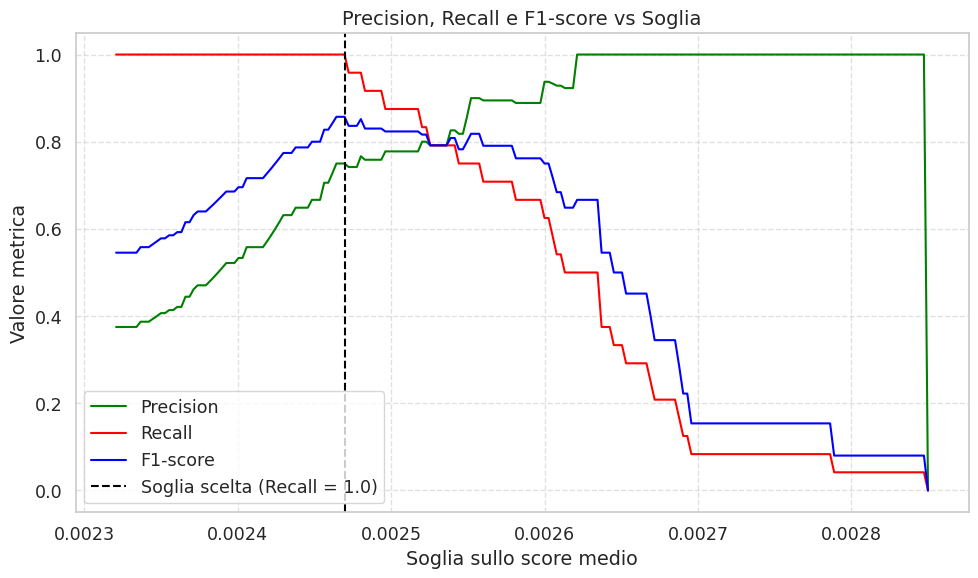

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Lista soglie da testare
thresholds = np.linspace(df["mean"].min(), df["mean"].max(), 200)

# Liste per i risultati
precision_list = []
recall_list = []
f1_list = []

# Calcolo metriche per ogni soglia
for t in thresholds:
    preds = (df["mean"] > t).astype(int)
    precision_list.append(precision_score(df["label"], preds, zero_division=0))
    recall_list.append(recall_score(df["label"], preds, zero_division=0))
    f1_list.append(f1_score(df["label"], preds, zero_division=0))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label="Precision", color="green")
plt.plot(thresholds, recall_list, label="Recall", color="red")
plt.plot(thresholds, f1_list, label="F1-score", color="blue")

# Linea soglia ottimale (recall 1.0)
plt.axvline(0.002470, color='black', linestyle='--', label="Soglia scelta (Recall = 1.0)")

# Dettagli grafico
plt.title("Precision, Recall e F1-score vs Soglia", fontsize=14)
plt.xlabel("Soglia sullo score medio")
plt.ylabel("Valore metrica")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
import os
os.makedirs("outputs", exist_ok=True)
torch.save(model.state_dict(), "outputs/model.pth")
print("✅ Modello salvato in outputs/model.pth")


✅ Modello salvato in outputs/model.pth
